In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Using TensorFlow backend.


Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


# Training and evaluating a sample 1D convnet on IMDB data

In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [6]:
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

In [9]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 5s - loss: 1.4266 - acc: 0.4954 - val_loss: 0.7156 - val_acc: 0.4968
Epoch 2/10
20000/20000 [==============================] - 2s - loss: 0.6984 - acc: 0.5170 - val_loss: 0.6851 - val_acc: 0.5482
Epoch 3/10
20000/20000 [==============================] - 2s - loss: 0.6704 - acc: 0.5893 - val_loss: 0.6522 - val_acc: 0.6454
Epoch 4/10
20000/20000 [==============================] - 2s - loss: 0.6041 - acc: 0.7057 - val_loss: 0.5606 - val_acc: 0.7228
Epoch 5/10
20000/20000 [==============================] - 2s - loss: 0.4897 - acc: 0.7941 - val_loss: 0.4916 - val_acc: 0.8022
Epoch 6/10
20000/20000 [==============================] - 2s - loss: 0.4203 - acc: 0.8312 - val_loss: 0.4520 - val_acc: 0.8250
Epoch 7/10
20000/20000 [==============================] - 2s - loss: 0.3863 - acc: 0.8479 - val_loss: 0.4606 - val_acc: 0.8342
Epoch 8/10
20000/20000 [==============================] - 2s -

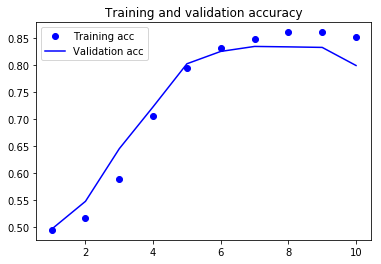

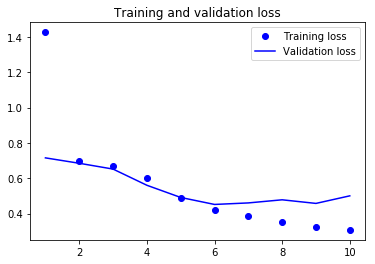

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Applying on Weather data

In [11]:
import os
data_dir = 'E:\\Datasets'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname, encoding='utf-8')
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [12]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
print(float_data[0])

[  9.96520000e+02  -8.02000000e+00   2.65400000e+02  -8.90000000e+00
   9.33000000e+01   3.33000000e+00   3.11000000e+00   2.20000000e-01
   1.94000000e+00   3.12000000e+00   1.30775000e+03   1.03000000e+00
   1.75000000e+00   1.52300000e+02]


In [13]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [14]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size = 128, step = 6):
    """
    data : The original array of floating-point data, which you normalized in listing 6.32.
    lookback : How many timesteps back the input data should go.
    delay : How many timesteps in the future the target should be.
    min_index and max_index : Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.    shuffle—Whether to shuffle the samples or draw them in chronological order.
    batch_size : The number of samples per batch.
    step : The period, in timesteps, at which you sample data. You’ll set it to 6 in order to draw one data point every hour
    """
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)
            
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets   

In [15]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

# Building a 1d CNN model

In [16]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

In [17]:
model.compile(optimizer=RMSprop(), loss='mse')

In [20]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data = val_gen,
                              validation_steps = 500
                             )

Epoch 1/20
500/500 [==============================] - 10s - loss: 0.3072 - val_loss: 0.3082
Epoch 2/20
500/500 [==============================] - 9s - loss: 0.2485 - val_loss: 0.3136
Epoch 3/20
500/500 [==============================] - 9s - loss: 0.2147 - val_loss: 0.2963
Epoch 4/20
500/500 [==============================] - 10s - loss: 0.1915 - val_loss: 0.3137
Epoch 5/20
500/500 [==============================] - 9s - loss: 0.1716 - val_loss: 0.3248
Epoch 6/20
500/500 [==============================] - 9s - loss: 0.1594 - val_loss: 0.3248
Epoch 7/20
500/500 [==============================] - 9s - loss: 0.1479 - val_loss: 0.3477
Epoch 8/20
500/500 [==============================] - 9s - loss: 0.1391 - val_loss: 0.3698
Epoch 9/20
500/500 [==============================] - 9s - loss: 0.1340 - val_loss: 0.3510
Epoch 10/20
500/500 [==============================] - 9s - loss: 0.1260 - val_loss: 0.3522
Epoch 11/20
500/500 [==============================] - 9s - loss: 0.1225 - val_loss: 0.

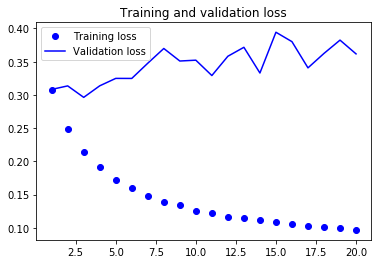

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Combining the 1d ConvNet with LSTM or GRU
The validation MAE stays in the 0.40s: you can’t even beat the common-sense baseline
using the small convnet. Again, this is because the convnet looks for patterns anywhere in the input timeseries and has no knowledge of the temporal position of a pattern it sees (toward the beginning, toward the end, and so on). Because more recent
data points should be interpreted differently from older data points in the case of this
specific forecasting problem, the convnet fails at producing meaningful results. This
limitation of convnets isn’t an issue with the IMDB data, because patterns of keywords
associated with a positive or negative sentiment are informative independently of
where they’re found in the input sentences.
One strategy to combine the speed and lightness of convnets with the order-sensitivity
of RNNs is to use a 1D convnet as a preprocessing step before an RNN (see figure 6.30).
This is especially beneficial when you’re dealing with sequences that are so long they can’t
realistically be processed with RNNs, such as
sequences with thousands of steps. The convnet will turn the long input sequence into
much shorter (downsampled) sequences of
higher-level features. This sequence of
extracted features then becomes the input to
the RNN part of the network.
This technique isn’t seen often in
research papers and practical applications,
possibly because it isn’t well known. It’s effective and ought to be more common. Let’s try
it on the temperature-forecasting dataset.
Because this strategy allows you to manipulate much longer sequences

In [23]:
lookback = 720
step = 3
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [24]:
model = Sequential()

model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 54s - loss: 0.3396 - val_loss: 0.3023
Epoch 2/20
500/500 [==============================] - 49s - loss: 0.3081 - val_loss: 0.2794
Epoch 3/20
500/500 [==============================] - 48s - loss: 0.2973 - val_loss: 0.2734
Epoch 4/20
500/500 [==============================] - 46s - loss: 0.2916 - val_loss: 0.2730
Epoch 5/20
500/500 [==============================] - 47s - loss: 0.2870 - val_loss: 0.2677
Epoch 6/20
500/500 [==============================] - 47s - loss: 0.2820 - val_loss: 0.2833
Epoch 7/20
500/500 [==============================] - 48s - loss: 0.2755 - val_loss: 0.2729
Epoch 8/20
500/500 [==============================] - 47s - loss: 0.2725 - val_loss: 0.2887
Epoch 9/20
500/500 [==============================] - 47s - loss: 0.2685 - val_loss: 0.2886
Epoch 10/20
500/500 [==============================] - 47s - loss: 0.2658 - val_loss: 0.2843
Epoch 11/20
500/500 [==============================] - 47s - loss: 0.2608 - val